In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import seaborn as sns

# Project parameters
TICKERS = ['AAPL', 'MSFT', 'GOOG', 'DIA', 'SPY', 'BTC-USD', 'ETH-USD'] # stocks, ETFs, cryptos 
BENCHMARK = 'SPY' # chose since it is typical benchmark used for stocks
RISK_FREE_RATE = 0.04 # 4% annualized; based on current T-bills
TRADING_DAYS = 252

In [2]:
# Collect Data
raw = yf.download(
    TICKERS,
    start="2015-01-01",
    end="2025-01-01",
    progress=False,
    auto_adjust=True,
    group_by='column'
).ffill().dropna(how='all')

data_open  = raw['Open']
data_close = raw['Close']

raw.to_csv('market_data.csv')
data_open.to_csv('market_open_data.csv')
data_close.to_csv('market_close_data.csv')

In [3]:
# Returns
returns = data_close.pct_change().dropna(how='all')
bench_price = data_close[BENCHMARK].dropna()
bench_ret   = bench_price.pct_change().dropna()

def annualized_return(daily_returns: pd.Series) -> float:
    return (1.0 + daily_returns.mean())**TRADING_DAYS - 1.0

def annualized_volatility(daily_returns: pd.Series) -> float:
    return daily_returns.std() * np.sqrt(TRADING_DAYS)

def sharpe_ratio(ann_return: float, ann_vol: float, risk_free_rate: float = RISK_FREE_RATE) -> float:
    if ann_vol == 0:
        return np.nan
    return (ann_return - risk_free_rate) / ann_vol

def max_drawdown(price_series: pd.Series) -> float:
    running_max = price_series.cummax()
    drawdown = price_series / running_max - 1.0
    return float(drawdown.min())

def beta(asset_returns: pd.Series, benchmark_returns: pd.Series) -> float:
    df = pd.concat([asset_returns, benchmark_returns], axis=1, keys=['asset', 'bench']).dropna()
    if df.shape[0] < 2:
        return np.nan
    var_b = df['bench'].var()
    if var_b == 0 or np.isnan(var_b):
        return np.nan
    return df['asset'].cov(df['bench']) / var_b

# Compute asset-level metrics
rows = []
for t in data_close.columns:
    r = returns[t].dropna()
    if r.empty:
        continue
    ann_ret = annualized_return(r)
    ann_vol = annualized_volatility(r)
    sr = sharpe_ratio(ann_ret, ann_vol, RISK_FREE_RATE)
    mdd = max_drawdown(data_close[t].loc[r.index])
    b = beta(r, bench_ret)

    rows.append({
        "Ticker": t,
        "Annualized Return": ann_ret,
        "Annualized Volatility": ann_vol,
        f"Sharpe (rf={RISK_FREE_RATE:.2%})": sr,
        f"Beta vs {BENCHMARK}": b,
        "Max Drawdown": mdd
    })

metrics = pd.DataFrame(rows).set_index("Ticker").sort_values(f"Sharpe (rf={RISK_FREE_RATE:.2%})", ascending=False)
metrics.to_csv("asset_metrics.csv")

=== Portfolio Summary (annualized) ===
               Portfolio  Annualized Return  Volatility  Sharpe
0  Tangency (Max Sharpe)             0.3168      0.2621  1.0562
1       Minimum Variance             0.0961      0.1436  0.3909

=== Tangency Weights (top 10) ===
MSFT       0.346132
BTC-USD    0.342762
AAPL       0.300878
SPY        0.010228
dtype: float64

=== Min-Variance Weights (top 10) ===
GOOG       0.534617
ETH-USD    0.451672
MSFT       0.013711
dtype: float64


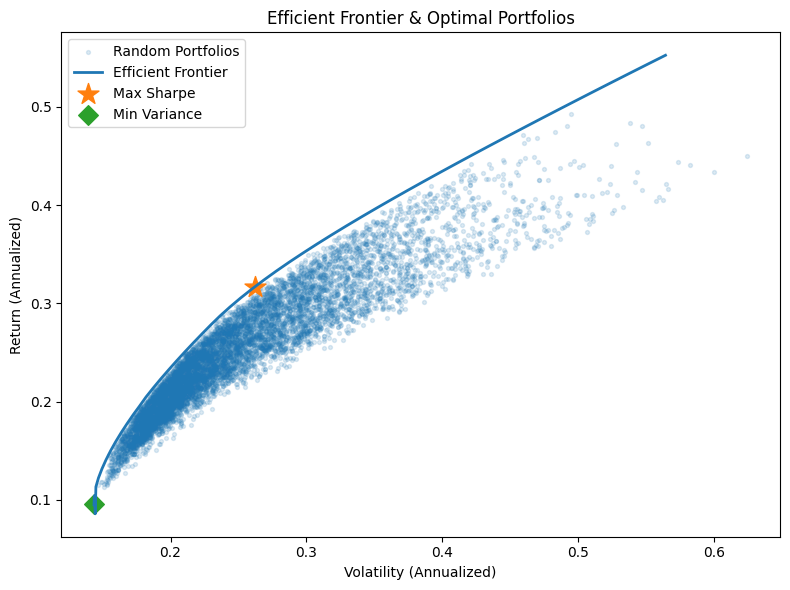

In [4]:
# Efficient Frontier + Max-Sharpe
try:
    import scipy.optimize as sco
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

ASSETS = [c for c in TICKERS if c in returns.columns]
n = len(ASSETS)

# Annualized inputs
mu_annual  = returns.mean() * TRADING_DAYS  # annualized expected return vector     # vector μ
cov_annual = returns.cov() * TRADING_DAYS # annualized covariance matrix of returns # matrix Σ
cov_annual_ridge = cov_annual + np.eye(n) * 1e-8 # adds a tiny value to the diagonal (ridge) to avoid numerical issues if assets are highly correlated or data are limited

def port_stats(weights: np.ndarray, rf: float = RISK_FREE_RATE):
    """
    given the weights compute return, volatility, and Sharpe
    """
    w = np.array(weights)
    r = float(np.dot(w, mu_annual.values)) # annualized return
    v = float(np.sqrt(w @ cov_annual_ridge.values @ w)) # annualized volatility
    s = np.nan if v == 0 else (r - rf) / v # Sharpe ratio
    return r, v, s

def pretty_weights(w: np.ndarray, tickers=ASSETS, top=10):
    """
    display the largest allocations (ignores tiny weights)
    """
    s = pd.Series(w, index=tickers).sort_values(ascending=False)
    return s[s > 1e-6].head(top)

### Optimization helpers
# Max Sharpe (Tangency) Portfolio
def max_sharpe_weights(allow_short: bool = False):
    """
    maximize Sharpe
    """
    bounds = [(-1, 1)] * n if allow_short else [(0, 1)] * n
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)

    def neg_sharpe(w):
        r, v, s = port_stats(w)
        return -s

    w0 = np.ones(n) / n
    if HAVE_SCIPY:
        res = sco.minimize(neg_sharpe, w0, method='SLSQP', bounds=bounds, constraints=cons)
        w = res.x
    else:
        # Monte Carlo fallback
        draws = 50000
        if allow_short:
            # sample from normal then project to sum=1
            W = np.random.randn(draws, n)
            W = W / W.sum(axis=1, keepdims=True)
        else:
            W = np.random.dirichlet(np.ones(n), size=draws)  # long-only simplex
        rs = W @ mu_annual.values
        vs = np.sqrt(np.einsum('ij,jk,ik->i', W, cov_annual_ridge.values, W))
        sharpe = (rs - RISK_FREE) / vs
        w = W[np.nanargmax(sharpe)]
    return w

# Global Minimum Variance (GMV) Portfolio
def min_variance_weights(allow_short: bool = False):
    """
    minimize portfolio variance
    """
    bounds = [(-1, 1)] * n if allow_short else [(0, 1)] * n
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)

    def variance(w):
        return float(w @ cov_annual_ridge.values @ w)

    w0 = np.ones(n) / n
    if HAVE_SCIPY:
        res = sco.minimize(variance, w0, method='SLSQP', bounds=bounds, constraints=cons)
        return res.x
    else:
        # Monte Carlo fallback
        draws = 50000
        if allow_short:
            W = np.random.randn(draws, n)
            W = W / W.sum(axis=1, keepdims=True)
        else:
            W = np.random.dirichlet(np.ones(n), size=draws)
        var = np.einsum('ij,jk,ik->i', W, cov_annual_ridge.values, W)
        return W[np.argmin(var)]

# Efficient Frontier
def efficient_frontier(num_points: int = 50, allow_short: bool = False):
    """
    Compute the efficient frontier by minimizing variance for a grid of target returns.
    Returns a DataFrame with target_return, volatility, and weights as columns.
    """
    if not HAVE_SCIPY:
        # Monte Carlo approximation to frontier
        draws = 100000
        if allow_short:
            W = np.random.randn(draws, n); W = W / W.sum(axis=1, keepdims=True)
        else:
            W = np.random.dirichlet(np.ones(n), size=draws)
        rs = W @ mu_annual.values
        vs = np.sqrt(np.einsum('ij,jk,ik->i', W, cov_annual_ridge.values, W))
        df = pd.DataFrame({'return': rs, 'vol': vs})
        # For visualization: keep the upper envelope by vol bins (max return for bins of vol)
        bins = pd.qcut(df['vol'], q=num_points, duplicates='drop')
        frontier = df.groupby(bins).apply(lambda x: x.loc[x['return'].idxmax()]).reset_index(drop=True)
        frontier.rename(columns={'return': 'target_return', 'vol': 'volatility'}, inplace=True)
        frontier_weights = pd.DataFrame(W, columns=ASSETS).loc[frontier.index].reset_index(drop=True)
        return pd.concat([frontier, frontier_weights], axis=1)

    # With SciPy: true frontier by minimizing variance at fixed target returns
    bounds = [(-1, 1)] * n if allow_short else [(0, 1)] * n
    ones = np.ones(n)

    # Choose target returns between min and max individual asset means or slightly beyond
    r_min, r_max = float(mu_annual.min()), float(mu_annual.max())
    targets = np.linspace(r_min*0.9, r_max*1.1, num_points)

    rows = []
    for r_target in targets:
        def objective(w):
            return float(w @ cov_annual_ridge.values @ w)
        cons = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}, # weight sum to 1
            {'type': 'eq', 'fun': lambda w, rt=r_target: np.dot(w, mu_annual.values) - rt}, # hit target return
        )
        w0 = np.ones(n)/n
        res = sco.minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=cons)
        if not res.success:
            continue
        w = res.x
        r, v, s = port_stats(w)
        row = {'target_return': r, 'volatility': v, 'sharpe': s}
        row.update({t: w[i] for i, t in enumerate(ASSETS)})
        rows.append(row)

    return pd.DataFrame(rows).sort_values('volatility').reset_index(drop=True)

# Run the optimizations
ALLOW_SHORT = False  # toggle to allow/disallow shorting # Currently: disallowed

w_tan = max_sharpe_weights(allow_short=ALLOW_SHORT)
w_min = min_variance_weights(allow_short=ALLOW_SHORT)
frontier = efficient_frontier(num_points=60, allow_short=ALLOW_SHORT)

# Summarize
tan_r, tan_v, tan_s = port_stats(w_tan)
min_r, min_v, min_s = port_stats(w_min)

summary = pd.DataFrame([
    {'Portfolio': 'Tangency (Max Sharpe)', 'Annualized Return': tan_r, 'Volatility': tan_v, 'Sharpe': tan_s},
    {'Portfolio': 'Minimum Variance',      'Annualized Return': min_r, 'Volatility': min_v, 'Sharpe': min_s},
])

weights_df = pd.DataFrame([w_tan, w_min], columns=ASSETS, index=['Tangency (Max Sharpe)', 'Minimum Variance'])
frontier.to_csv('portfolio_efficient_frontier.csv', index=False)
weights_df.to_csv('portfolio_optimal_weights.csv')
summary.to_csv('portfolio_summary.csv', index=False)

print("=== Portfolio Summary (annualized) ===")
print(summary.round(4))
print("\n=== Tangency Weights (top 10) ===")
print(pretty_weights(w_tan))
print("\n=== Min-Variance Weights (top 10) ===")
print(pretty_weights(w_min))

### Visuals

# Monte Carlo scatter plot
draws = 8000
W = np.random.dirichlet(np.ones(n), size=draws) if not ALLOW_SHORT else (np.random.randn(draws, n) / np.random.randn(draws, n).sum(axis=1, keepdims=True))
mc_r = W @ mu_annual.values
mc_v = np.sqrt(np.einsum('ij,jk,ik->i', W, cov_annual_ridge.values, W))

plt.figure(figsize=(8,6))
plt.scatter(mc_v, mc_r, alpha=0.15, s=8, label='Random Portfolios')
plt.plot(frontier['volatility'], frontier['target_return'], linewidth=2, label='Efficient Frontier')
plt.scatter([tan_v], [tan_r], marker='*', s=250, label='Max Sharpe')
plt.scatter([min_v], [min_r], marker='D', s=100, label='Min Variance')
plt.xlabel('Volatility (Annualized)')
plt.ylabel('Return (Annualized)')
plt.title('Efficient Frontier & Optimal Portfolios')
plt.legend()
plt.tight_layout()
plt.savefig('efficient_frontier.png', dpi=160)
plt.show()

In [5]:
# Beta Calculations
def beta(asset_returns: pd.Series, benchmark_returns: pd.Series) -> float:
    """
    Compute Capital Asset Pricing Model (CAPM) beta for a single asset vs. benchmark.
    Returns NaN if not enough data or zero benchmark variance.
    """
    df = pd.concat([asset_returns, benchmark_returns], axis=1, keys=["asset", "bench"]).dropna()
    if df.shape[0] < 2:
        return np.nan
    var_b = df["bench"].var()
    if var_b == 0 or np.isnan(var_b):
        return np.nan
    return df["asset"].cov(df["bench"]) / var_b

def beta_bulk(returns_df: pd.DataFrame, benchmark_col: str) -> pd.Series:
    """
    Vectorized beta for many assets in returns_df against returns_df[benchmark_col].
    Returns betas indexed by column name.
    """
    # Keep only columns with the benchmark present
    cols = [c for c in returns_df.columns if c != benchmark_col] + [benchmark_col]
    sub = returns_df[cols].dropna(how="all")
    cov = sub.cov()  # pairwise NaN handling
    var_b = cov.loc[benchmark_col, benchmark_col]
    if var_b == 0 or np.isnan(var_b):
        return pd.Series(np.nan, index=sub.columns.drop(benchmark_col))
    betas = cov[benchmark_col] / var_b
    return betas.drop(index=benchmark_col)

def rolling_beta(asset_returns: pd.Series, benchmark_returns: pd.Series,
                 window: int = 126, min_periods: int | None = None) -> pd.Series:
    """
    Rolling beta using a moving window (default ~6 months of trading days).
    """
    if min_periods is None:
        min_periods = max(20, window // 4)  # sensible default
    aligned = pd.concat([asset_returns, benchmark_returns], axis=1, keys=["asset", "bench"]).dropna()
    cov_roll = aligned["asset"].rolling(window, min_periods=min_periods).cov(aligned["bench"])
    var_roll = aligned["bench"].rolling(window, min_periods=min_periods).var()
    return cov_roll / var_roll

# Single asset beta
aapl_beta = beta(returns['AAPL'], bench_ret)

# All tickers vs SPY in one shot
betas = beta_bulk(returns, BENCHMARK)  # returns a Series

# Rolling 6-month beta for AAPL (30 trading days)
aapl_beta_roll = rolling_beta(returns['AAPL'], bench_ret, window=30)

print(aapl_beta)
print(betas)
print(aapl_beta_roll)

1.2078758091330486
Ticker
AAPL       1.207876
BTC-USD    0.805713
DIA        0.944798
ETH-USD    1.492821
GOOG       1.160172
MSFT       1.225985
Name: SPY, dtype: float64
Date
2015-01-03         NaN
2015-01-04         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
                ...   
2024-12-27    0.705511
2024-12-28    0.705511
2024-12-29    0.692314
2024-12-30    0.746717
2024-12-31    0.759994
Freq: D, Length: 3651, dtype: float64


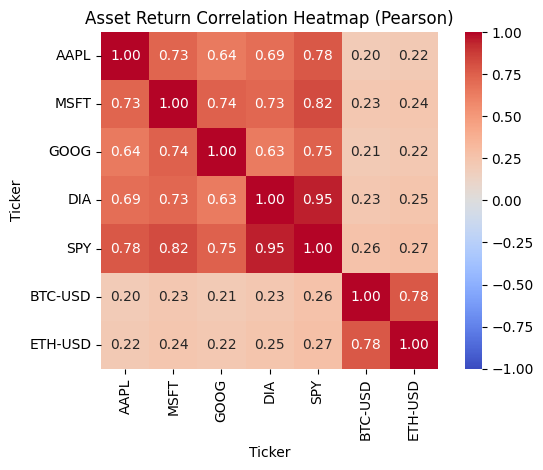

In [6]:
# Asset Return Correlation Heatmap
method = "pearson"   # select pearson or spearman
corr = returns[ASSETS].dropna().corr(method=method)

ax = sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", square=True)
ax.set_title(f"Asset Return Correlation Heatmap ({method.title()})")
ax.figure.tight_layout()
ax.figure.savefig("correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

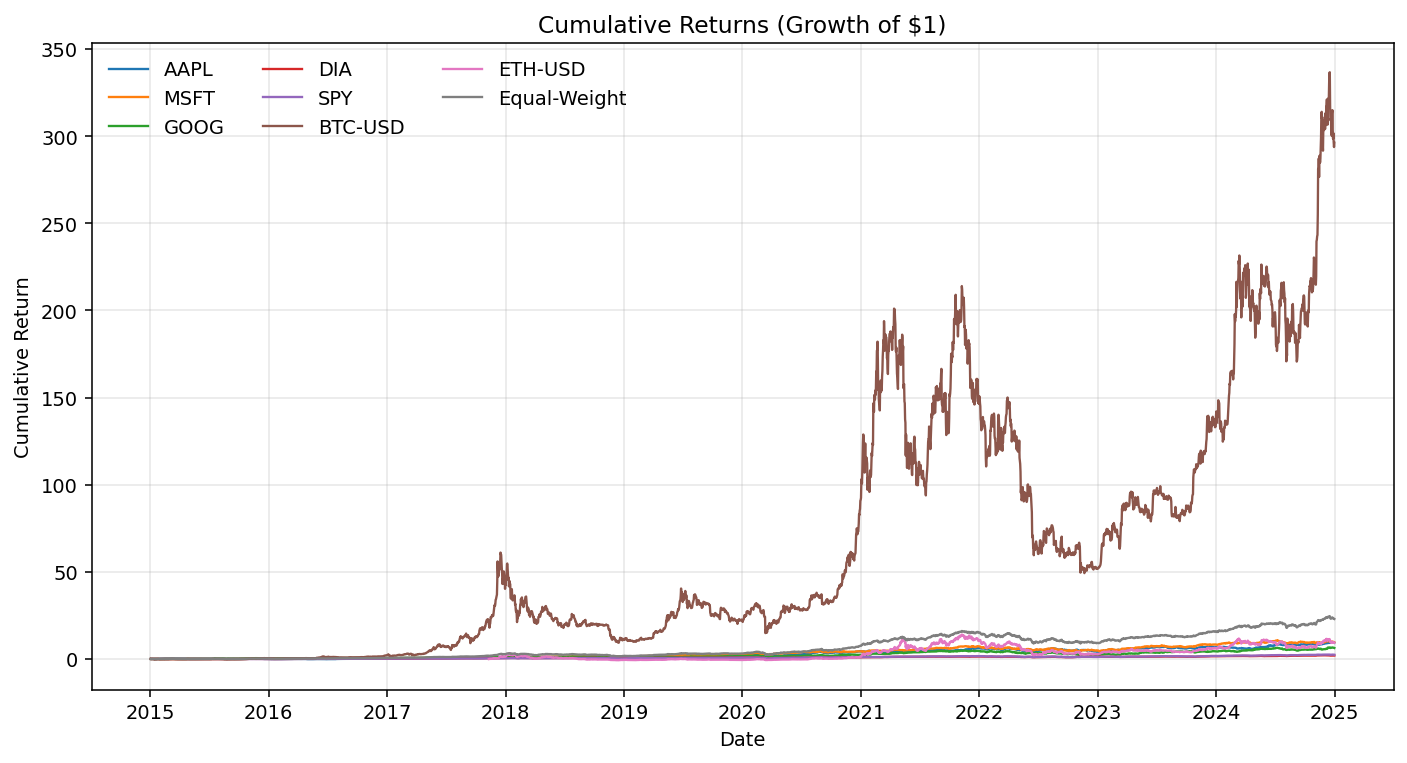

In [7]:
# Cummlative Returns Graph
cum_ret = (1 + returns[ASSETS]).dropna(how="all").cumprod() - 1

if len(ASSETS) > 0:
    ew_daily = returns[ASSETS].mean(axis=1) # equal-weight daily return
    ew_cum   = (1 + ew_daily).dropna().cumprod() - 1
    cum_ret["Equal-Weight"] = ew_cum

fig, ax = plt.subplots(figsize=(12, 6), dpi=140)

for col in cum_ret.columns:
    ax.plot(cum_ret.index, cum_ret[col], linewidth=1.2, label=col)

ax.set_title("Cumulative Returns (Growth of $1)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")
ax.legend(ncol=3, frameon=False, loc="best")
ax.grid(True, alpha=0.3)
fig.savefig("cumulative_returns.png", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

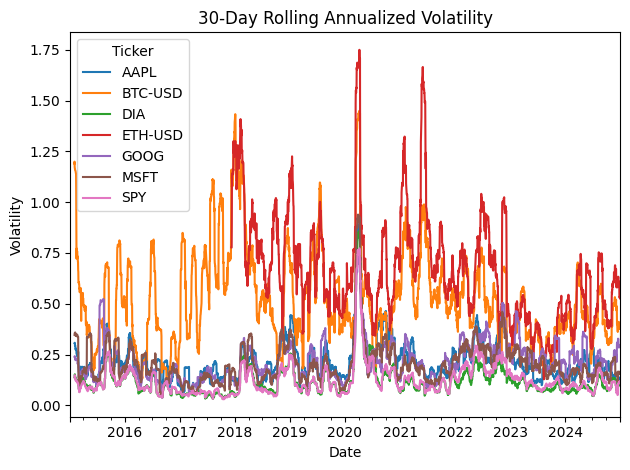

In [8]:
# 30-Day Rolling Annualized Volatility Graph
ROLLING_WINDOW = 30 # rolling window can be changed

plt.figure()
(returns.rolling(ROLLING_WINDOW).std() * np.sqrt(TRADING_DAYS)).plot()
plt.title(f"{ROLLING_WINDOW}-Day Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.tight_layout()
plt.savefig(f"{ROLLING_WINDOW}-Day Rolling Annualized Volatility — {col}", dpi=300, bbox_inches='tight')
plt.show()